In [78]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [79]:
# Read data
trainData = pd.read_table("NormalData.csv", sep=",")
trainDX = trainData[trainData.columns.values[:-1]]
trainDY = trainData[["class"]]

In [80]:
def knn_train(trainX, trainY, k):
    # Set the seed
    random.seed(1)
    # Divide indices of data into 10 folds randomly
    row = trainX.shape[0]
    index = [int(i) for i in np.linspace(0, row-1, row)]
    random.shuffle(index)
    AUC = []
    # Use 10-fold cross validation to estimate the error rate
    folds = 10
    for i in range(0, folds):
        # For each fold, calculate the accuracy
        vali_index = index[int(row/folds*i):int(row/folds*(i+1))]
        # Train set has 9 folds and validation set has 1 fold
        vali_x = trainX.iloc[vali_index]
        train_x = trainX.iloc[list(set(index)-set(vali_index))]
        for j in range(0, vali_x.shape[0]):
            sample = vali_x.iloc[[j]]
            diff = np.tile(sample, (len(train_x), 1)) - train_x
            dis = np.sqrt((diff**2).sum(axis=1))
            dis_dict = pd.DataFrame(dis).to_dict()[0]
            sort_dis = sorted(dis_dict.items(), key=lambda item:item[1])
            neigh = trainY["class"][[a[0] for a in sort_dis[:k]]]
            neigh_l = list(neigh)
            true = trainY["class"][vali_x.iloc[[j]].index[0]]
            num = neigh_l.count(1)
            ratio = num/k
            AUC.append([ratio,true])
        # Calculate the accuracy rate
    return(AUC)
            

In [81]:
thresholds = np.linspace(0,1,100)
k_choices = np.linspace(1,10,10)
FPR_df = []
TPR_df = []
interal_list = []
for k in k_choices:
    AUC = knn_train(trainDX, trainDY, int(k))
    prob = [i[0] for i in AUC]
    label = [i[1] for i in AUC]
    FPR_list = []
    TPR_list = []
    for t in thresholds:
        pred = [int(i>=t) for i in prob]
        TP = len([i for i in range(len(pred)) if pred[i]==1 and label[i]==1])
        FP = len([i for i in range(len(pred)) if pred[i]==1 and label[i]==0])
        TN = len([i for i in range(len(pred)) if pred[i]==0 and label[i]==0])
        FN = len([i for i in range(len(pred)) if pred[i]==0 and label[i]==1])
        FPR = FP/(FP+TN)
        TPR = TP/(TP+FN)
        FPR_list.append(FPR)
        TPR_list.append(TPR)
    FPR_df.append(FPR_list)
    TPR_df.append(TPR_list)
 

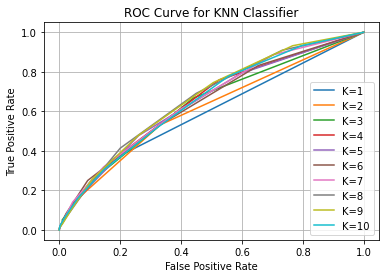

In [82]:
# ROC plot
fig = plt.figure()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
for i in range(10):
    plt.plot(FPR_df[i],TPR_df[i],label="K="+str(int(i+1)))
plt.title("ROC Curve for KNN Classifier")
plt.legend()
plt.show()   

In [83]:
# AUC approximation
integral_list = []
for i in range(10):
    xlist = FPR_df[i]
    ylist = TPR_df[i]
    xpoints = sorted(list(set(xlist)))
    ypoints = sorted(list(set(ylist)))
    integral = 0
    for i in range(len(xpoints)-1):
        integral += 1/2*(ypoints[i]+ypoints[i+1])*(xpoints[i+1]-xpoints[i])
    integral_list.append(integral)
print(integral_list)
                
        

[0.5583645092904352, 0.6071673525377229, 0.6340971442823294, 0.6468231699713181, 0.6434592842000249, 0.6428388826536975, 0.6521480234443198, 0.46296296296296297, 0.2933564035415887, 0.4784542960468886]


In [ ]:
\begin{python}
# Define sigmoid function
def sigmoid(x):
    return 1.0/(1+np.exp(-x))
\end{python}

\begin{python}
# Define Gradient Descent Method without regularization
def gradientDescent(X,Y):
    dataMatrix = np.mat(X)
    classMatrix = np.mat(Y)
    num_sample, num_parameter = np.shape(dataMatrix)
    #initialize the weights
    weights1 = np.zeros((num_parameter,1))
    weights2 = np.zeros((num_parameter,1))
    step_size = 0.01
    max_iter = 50000
    episilon = 0.0000001
    num_iter = 0
    while(num_iter < max_iter):
        num_iter+=1
        weights2 = weights1
        y = sigmoid(dataMatrix*weights1)
        error = y - classMatrix 
        weights1 = weights1 - (step_size)*dataMatrix.transpose()*error/len(classMatrix)
        if all(abs(weights2-weights1) < episilon):
            break
    return weights1
\end{python}

\begin{python}
def logistic(train_X,train_Y,test_X,test_Y):
    temp_weight = gradientDescent(train_X,train_Y)
    pred_train_Y = pd.DataFrame(sigmoid(train_X.to_numpy()*temp_weight))
    #classify the prediction results for training set
    for i in range(len(pred_train_Y)):
        if pred_train_Y.iloc[i,0] <=0.5:
            pred_train_Y.iloc[i,0] = 0
        else:
            pred_train_Y.iloc[i,0] = 1       
    TP_train = 0
    FP_train = 0
    TN_train = 0
    FN_train = 0
    #calculate TP,FP,TN,FN
    for j in range(len(pred_train_Y)):
        if (pred_train_Y.iloc[j,0] == 1 and train_Y.iloc[j,0] == 1):
            TP_train += 1
        elif (pred_train_Y.iloc[j,0] == 1 and train_Y.iloc[j,0] == 0):
            FP_train += 1
        elif (pred_train_Y.iloc[j,0] == 0 and train_Y.iloc[j,0] == 0):
            TN_train += 1
        else:
            FN_train += 1
        
    train_precision = TP_train/(TP_train + FP_train)
    train_recall = TP_train/(TP_train + FN_train)
    train_F1_score = 2*train_precision*train_recall/(train_precision+train_recall)
    
    #classify the prediction results for the test set
    pred_test_Y = pd.DataFrame(sigmoid(test_X.to_numpy()*temp_weight))
    for m in range(len(pred_test_Y)):
        if pred_test_Y.iloc[m,0] <=0.5:
            pred_test_Y.iloc[m,0] = 0
        else:
            pred_test_Y.iloc[m,0] = 1       
    TP_test = 0
    FP_test = 0
    TN_test = 0
    FN_test = 0
    #calculate TP,FP,TN,FN
    for n in range(len(pred_test_Y)):
        if (pred_test_Y.iloc[n,0] == 1 and test_Y.iloc[n,0] == 1):
            TP_test += 1
        elif (pred_test_Y.iloc[n,0] == 1 and test_Y.iloc[n,0] == 0):
            FP_test += 1
        elif (pred_test_Y.iloc[n,0] == 0 and test_Y.iloc[n,0] == 0):
            TN_test += 1
        else:
            FN_test += 1
        
    test_precision = TP_test/(TP_test + FP_test)
    test_recall = TP_test/(TP_test + FN_test)
    test_F1_score = 2*test_precision*test_recall/(test_precision+test_recall)
    
    return(train_precision,train_recall,train_F1_score,test_precision,test_recall,test_F1_score)
\end{python}






\begin{python}
#define gradient descent with regularization
def gradientDescent_reg(X,Y,lam):
    dataMatrix = np.mat(X)
    classMatrix = np.mat(Y)
    num_sample, num_parameter = np.shape(dataMatrix)
    #initialize the weights
    weights1 = np.zeros((num_parameter,1))
    weights2 = np.zeros((num_parameter,1))
    step_size = 0.01
    max_iter = 50000
    episilon = 0.0000001
    num_iter = 0
    while(num_iter < max_iter):
        num_iter+=1
        weights2 = weights1
        y = sigmoid(dataMatrix*weights1)
        error = y - classMatrix 
        weights1 = weights1 - (step_size)*(dataMatrix.transpose()*error+lam*weights1)/len(classMatrix)
        if all(abs(weights2-weights1) < episilon):
            break
    return weights1
\end{python}

\begin{python}
#Define cross-validation for logistic with regularization to test accuracy
def cross_validation_regularize(X,Y,lam):
    #Create the fold to save precision
    precision_train = []
    precision_vali = []
    recall_train = []
    recall_vali = []
    # Set the seed
    random.seed(1)
    # Divide indices of data into 10 folds randomly
    row = X.shape[0]
    index = [int(i) for i in np.linspace(0, row-1, row)]
    random.shuffle(index)
    # Use 10-fold cross validation to estimate the error rate
    folds = 10
    for i in range(0, folds):
        # For each fold, calculate the accuracy
        vali_index = index[int(row/folds*i):int(row/folds*(i+1))]
        # Train set has 9 folds and validation set has 1 fold
        vali_x = X.iloc[vali_index]
        vali_y = Y.iloc[vali_index]
        train_x = X.iloc[list(set(index)-set(vali_index))]
        train_y = Y.iloc[list(set(index)-set(vali_index))]
        temp_weight = gradientDescent_reg(train_x,train_y,lam)
        #predict result for the train set
        pred_train_y = sigmoid(train_x.to_numpy()*temp_weight)
        pred_train_y = pd.DataFrame(pred_train_y)
        for j in range(len(pred_train_y)):
            if pred_train_y.iloc[j,0] <= 0.5:
                pred_train_y.iloc[j,0] = 0
            else:
                pred_train_y.iloc[j,0] = 1
        TP_train = 0
        FP_train = 0
        FN_train = 0
        TN_train = 0
        for k in range(len(pred_train_y)):
            if pred_train_y.iloc[k,0] == 1 and train_y.iloc[k,0] == 1:
                TP_train+=1
            elif pred_train_y.iloc[k,0] == 1 and train_y.iloc[k,0] == 0:
                FP_train+=1
            elif pred_train_y.iloc[k,0] == 0 and train_y.iloc[k,0] == 1:
                FN_train+=1
            else:
                TN_train+=1
        precision_train.append(TP_train/(TP_train+FP_train))
        recall_train.append(TP_train/(TP_train + FN_train))
        #predict result for the test set
        pred_vali_y = sigmoid(vali_x.to_numpy()*temp_weight)
        pred_vali_y = pd.DataFrame(pred_vali_y)
        for j in range(len(pred_vali_y)):
            if pred_vali_y.iloc[j,0] <= 0.5:
                pred_vali_y.iloc[j,0] = 0
            else:
                pred_vali_y.iloc[j,0] = 1
        TP_vali = 0
        FP_vali = 0
        FN_vali = 0
        TN_vali = 0
        for k in range(len(pred_vali_y)):
            if pred_vali_y.iloc[k,0] == 1 and vali_y.iloc[k,0] == 1:
                TP_vali+=1
            elif pred_vali_y.iloc[k,0] == 1 and vali_y.iloc[k,0] == 0:
                FP_vali+=1
            elif pred_vali_y.iloc[k,0] == 0 and vali_y.iloc[k,0] == 1:
                FN_vali+=1
            else:
                TN_vali+=1
        if(TP_vali+FP_vali != 0):
            precision_vali.append(TP_vali/(TP_vali+FP_vali))
        else:
            precision_vali.append(None)
        recall_vali.append(TP_vali/(TP_vali+FN_vali))
        
        
        
    F1_train = [2*precision_train[i]*recall_train[i]/(precision_train[i]+recall_train[i]) for i in range(len(precision_train))]    
    F1_vali = [2*precision_vali[i]*recall_vali[i]/(precision_vali[i]+recall_vali[i]) for i in range(len(precision_vali)) if precision_vali != None and (precision_vali[i]+recall_vali[i]) != 0]
    precision_vali = list(filter(None,precision_vali))
    return(np.mean(precision_train),np.mean(recall_train),np.mean(F1_train),np.mean(precision_vali),np.mean(recall_vali),np.mean(F1_vali))
\end{python}









\begin{python}
# Transform the trainDY and testDY into two columns
trainDY["class2"] = 0
testDY["class2"] = 0

for i in range(949):
    if trainDY.iloc[i,0] == 0.0:
        trainDY.iloc[i,0] = 1
        trainDY.iloc[i,1] = 0
    else:
        trainDY.iloc[i,0] = 0
        trainDY.iloc[i,1] = 1
        
for j in range(151):
    if testDY.iloc[j,0] == 0.0:
        testDY.iloc[j,0] = 1
        testDY.iloc[j,1] = 0
    else:
        testDY.iloc[j,0] = 0
        testDY.iloc[j,1] = 1
\end{python}

\begin{python}
# Define the softmax function
def softmax(X):
    
    num_sample, num_class = X.shape
    for i in range(num_sample):
        denom = np.exp(X[i]).sum()
        X[i] = np.exp(X[i])/denom
    return(X)
\end{python}

\begin{python}
# Define gradient descent for softmax without regularization
# k implies the number of classes
def gradientDescent(X,Y,k):
    dataMatrix = np.mat(X)
    classMatrix = np.mat(Y)
    num_sample, num_parameter = dataMatrix.shape
    weight1 = np.ones([num_parameter,k])
    weight2 = np.ones([num_parameter,k])
    step_size = 1
    max_iter = 50000
    episilon = 0.000001
    num_iter = 0
    los = []
    while(num_iter < max_iter):
        num_iter += 1
        weight2 = weight1
        y = softmax(dataMatrix*weight1)
        error = y - classMatrix
        weight1 = weight1 - (step_size)*dataMatrix.transpose()*error/num_sample
        if (abs(weight2[:,0]-weight1[:,0]) < episilon).all():
            break
    return weight1
\end{python}









\begin{python}
# Define gradient descent for softmax with regularization
# k implies the number of classes
def gradientDescent_reg(X,Y,k,lam):
    dataMatrix = np.mat(X)
    classMatrix = np.mat(Y)
    num_sample, num_parameter = dataMatrix.shape
    weight1 = np.ones([num_parameter,k])
    weight2 = np.ones([num_parameter,k])
    step_size = 1
    max_iter = 2000
    episilon = 0.000001
    num_iter = 0
    los = []
    while(num_iter < max_iter):
        num_iter += 1
        weight2 = weight1
        y = softmax(dataMatrix*weight1)
        error = y - classMatrix
        weight1 = weight1 - (step_size)*(dataMatrix.transpose()*error+lam*weight1)/num_sample
        if (abs(weight2[:,0]-weight1[:,0]) < episilon).all():
            break
    return weight1
\end{python}

\begin{python}
#Define cross-validation for logistic with regularization to test accuracy
def cross_validation_regularize(X,Y,lam):
    #Create the fold to save precision
    precision_train = []
    precision_vali = []
    recall_train = []
    recall_vali = []
    accuracy_train = []
    accuracy_vali = []
    # Set the seed
    np.random.seed(1)
    # Divide indices of data into 10 folds randomly
    row = X.shape[0]
    index = [int(i) for i in np.linspace(0, row-1, row)]
    random.shuffle(index)
    # Use 10-fold cross validation to estimate the error rate
    folds = 10
    for i in range(0, folds):
        # For each fold, calculate the accuracy
        vali_index = index[int(row/folds*i):int(row/folds*(i+1))]
        # Train set has 9 folds and validation set has 1 fold
        vali_x = X.iloc[vali_index]
        vali_y = Y.iloc[vali_index]
        train_x = X.iloc[list(set(index)-set(vali_index))]
        train_y = Y.iloc[list(set(index)-set(vali_index))]
        temp_weight = gradientDescent_reg(train_x,train_y,2,lam)
        #predict result for the train set
        pred_train_y = softmax(train_x.to_numpy()*temp_weight)
        pred_train_y = pd.DataFrame(pred_train_y)
        temp_row, temp_col = pred_train_y.shape
        for j in range(temp_row):
            if pred_train_y.iloc[j,0] <= pred_train_y.iloc[j,1]:
                pred_train_y.iloc[j,0] = 0
                pred_train_y.iloc[j,1] = 1
            else:
                pred_train_y.iloc[j,0] = 1
                pred_train_y.iloc[j,1] = 0
                
        TP_train = 0
        FP_train = 0
        FN_train = 0
        TN_train = 0
        
        for k in range(temp_row):
            if pred_train_y.iloc[k,0] == 0 and train_y.iloc[k,0] == 0:
                TP_train+=1
            elif pred_train_y.iloc[k,0] == 0 and train_y.iloc[k,0] == 1:
                FP_train+=1
            elif pred_train_y.iloc[k,0] == 1 and train_y.iloc[k,0] == 0:
                FN_train+=1
            else:
                TN_train+=1
        precision_train.append(TP_train/(TP_train+FP_train))
        recall_train.append(TP_train/(TP_train + FN_train))
        accuracy_train.append((TP_train+TN_train)/(TP_train+TN_train+FP_train+FN_train))
        #predict result for the test set
        pred_vali_y = softmax(vali_x.to_numpy()*temp_weight)
        pred_vali_y = pd.DataFrame(pred_vali_y)
        temp_row2,temp_col2 = pred_vali_y.shape
        for j in range(temp_row2):
            if pred_vali_y.iloc[j,0] <= pred_vali_y.iloc[j,1]:
                pred_vali_y.iloc[j,0] = 0
                pred_vali_y.iloc[j,1] = 1
            else:
                pred_vali_y.iloc[j,0] = 1
                pred_vali_y.iloc[j,1] = 0
        TP_vali = 0
        FP_vali = 0
        FN_vali = 0
        TN_vali = 0
        for k in range(temp_row2):
            if pred_vali_y.iloc[k,0] == 0 and vali_y.iloc[k,0] == 0:
                TP_vali+=1
            elif pred_vali_y.iloc[k,0] == 0 and vali_y.iloc[k,0] == 1:
                FP_vali+=1
            elif pred_vali_y.iloc[k,0] == 1 and vali_y.iloc[k,0] == 0:
                FN_vali+=1
            else:
                TN_vali+=1
        if(TP_vali+FP_vali != 0):
            precision_vali.append(TP_vali/(TP_vali+FP_vali))
        else:
            precision_vali.append(0)
        recall_vali.append(TP_vali/(TP_vali+FN_vali))
        accuracy_vali.append((TP_vali+TN_vali)/(TP_vali+TN_vali+FP_vali+FN_vali))
        
        
    F1_train = [2*precision_train[i]*recall_train[i]/(precision_train[i]+recall_train[i]) for i in range(len(precision_train))]    
    F1_vali = [2*precision_vali[i]*recall_vali[i]/(precision_vali[i]+recall_vali[i]) for i in range(len(precision_vali)) if precision_vali != None and (precision_vali[i]+recall_vali[i]) != 0]
    precision_vali = list(filter(None,precision_vali))
    return(np.mean(accuracy_train),np.mean(precision_train),np.mean(recall_train),np.mean(F1_train),np.mean(accuracy_vali),np.mean(precision_vali),np.mean(recall_vali),np.mean(F1_vali))
\end{python}








def tree(para):
    train_acc = []
    train_pre = []
    train_rec = []
    train_f1 = []
    test_acc = []
    test_pre = []
    test_rec = []
    test_f1 = []
    for i in range(1,para): 
        clf = DecisionTreeClassifier(max_depth=para)
        clf = clf.fit(trainDX,trainDY)
        train_predict = clf.predict(trainDX)
        test_predict = clf.predict(testDX)
        #Compute the training accuracy, precision, recall and F1-score
        TP_train = 0
        TN_train = 0
        FP_train = 0
        FN_train = 0
        for i in range(len(train_predict)):
            if (train_predict[i] == 0 and trainDY[i] == 0):
                TN_train += 1
            elif (train_predict[i] == 1 and trainDY[i] == 1):
                TP_train += 1
            elif (train_predict[i] == 1 and trainDY[i] == 0):
                FP_train += 1
            else:
                FN_train += 1
        Accuracy_train = (TP_train+TN_train)/(TP_train+TN_train+FP_train+FN_train)
        Precision_train = TP_train/(TP_train + FP_train)
        Recall_train = TP_train/(TP_train + FN_train)
        F1_train = 2*Precision_train*Recall_train/(Precision_train + Recall_train)
        train_acc.append(Accuracy_train)
        train_pre.append(Precision_train)
        train_rec.append(Recall_train)
        train_f1.append(F1_train)
        #Compute the testing accuracy, precision, recall and F1-score
        TP_test = 0
        TN_test = 0
        FP_test = 0
        FN_test = 0
        for i in range(len(test_predict)):
            if (test_predict[i] == 0 and testDY[i] == 0):
                TN_test += 1
            elif (test_predict[i] == 1 and testDY[i] == 1):
                TP_test += 1
            elif (test_predict[i] == 1 and testDY[i] == 0):
                FP_test += 1
            else:
                FN_test += 1
        Accuracy_test = (TP_test+TN_test)/(TP_test+TN_test+FP_test+FN_test)
        Precision_test = TP_test/(TP_test + FP_test)
        Recall_test = TP_test/(TP_test + FN_test)
        F1_test = 2*Precision_test*Recall_test/(Precision_test + Recall_test)
        test_acc.append(Accuracy_test)
        test_pre.append(Precision_test)
        test_rec.append(Recall_test)
        test_f1.append(F1_test)
    return(train_acc,train_pre,train_rec,train_f1,test_acc,test_pre,test_rec,test_f1)
\end{python}

Metrics of the decision tree classifier are displayed in the following Figure 22.
\begin{figure}[htbp]
\centering
\includegraphics[width=.5\textwidth]{image/zht_image/DT.png}
\caption{Metrics of Decision Tree}\label{fig1}
\end{figure}